# Continuous Control
# Reacher Deep RL Nano Degree

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

The solution here is based on using Deep Deterministic Polocy gradients. The solution here hevily references this paper [DDPG](https://arxiv.org/pdf/1509.02971.pdf)

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [11]:
from unityagents import UnityEnvironment
import numpy as np
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [ ]:
env = UnityEnvironment(file_name='/home/neilkunal/Desktop/DeepRL/deep-reinforcement-learning/p2_continuous-control/Reacher_Linux_multi/Reacher_Linux/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

## Network Architecture

`model.py` defines the model architectures used.

It was found that the solution is heavily dependent on the noise parameter used. Where 0.15 was found to give agreeable results. 0.9 would not increase substantially in training.

The DDPG policy gradient agent is an actor critic method. here 3 fully connected laters are used for the actor. Here a 'tanh' activation function is used. The first 2 layers have 128 and 258 units respectfully.

```python
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm2d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

```

The critic model wass chosen to be similar to the actor model

In [7]:
from ddpg_agent import Agent
import matplotlib.pyplot as plt
from collections import deque
# num_agents=1
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)
agent.action_size

4

In [8]:
# def ddpg(n_episodes=1000, max_t=300, print_every=100):
#     scores_deque = deque(maxlen=print_every)
#     scores_list = []
#     for i_episode in range(1, n_episodes+1):
#         env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
#         state = env_info.vector_observations                 # get the current state (for each agent)
# #         scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        
# #         state = env.reset()
#         agent.reset()
#         scores = np.zeros(num_agents) 
#         for t in range(max_t):
#             action = agent.act(state)
# #             print(action)
# #             next_state, reward, done, _ = env.step(action)

# #             score += reward
#             env_info = env.step(action)[brain_name]           # send all actions to tne environment
#             next_state = env_info.vector_observations         # get next state (for each agent)
#             rewards = env_info.rewards                         # get reward (for each agent)
# #             print(reward)
#             dones = env_info.local_done                        # see if episode finished
            
#             agent.step(state, action, rewards, next_state, dones)
#             state = next_state
            
#             scores += rewards                         # update the score (for each agent)
#             if np.any(dones):
#                 break 
#         scores_deque.append(np.mean(scores))
#         scores_list.append(np.mean(scores))
#         print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
#         torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
#         torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
#         if i_episode % print_every == 0:
#             print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
#     return scores



## Training with a Deep Deterministic Policy Gradient Agent

In [9]:
def ddpg(n_episodes=1000, max_t=10000, print_every=100):
    """DDQN Algorithm.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): frequency of printing information throughout iteration """
    
    scores = []
    scores_deque = deque(maxlen=print_every)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        
        for t in range(max_t):
            action = agent.act(state)          # select an action
       
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done) # take step with agent (including learning)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        
        scores_deque.append(score)       # save most recent score
        scores.append(score)             # save most recent score

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

/home/neilkunal/.local/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 9.72
Episode 168	Average Score: 30.12
Environment solved in 168 episodes!	Average Score: 30.12


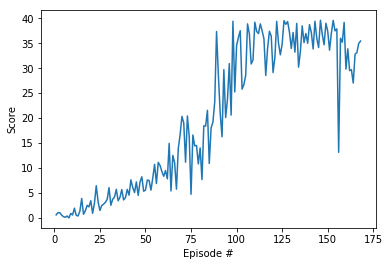

In [10]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
# load the weights from file
env = UnityEnvironment(file_name='/home/neilkunal/Desktop/DeepRL/deep-reinforcement-learning/p2_continuous-control/Reacher_Linux_multi/Reacher_Linux/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]
# 


In [ ]:
from ddpg_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

agent.actor_local.state_dict(torch.load( 'checkpoint_actor.pth'))
agent.critic_local.state_dict(torch.load( 'checkpoint_critic.pth'))
   

agent.qnetwork_local.load_state_dict(torch.load('Navigation_nopixels.pth'))
# env = UnityEnvironment(file_name="/home/neilkunal/Desktop/DeepRL/deep-reinforcement-learning/p1_navigation/Banana_Linux/Banana.x86_64")


for i in range(3):
#     state = env.reset()
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    for j in range(200):
        action = agent.act(state, 0.)

        env_info = env.step(action)[brain_name]        # send the action to the environment
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0] 
#         state, reward, done, _ = env.step(action)
        state = env_info.vector_observations[0]
        if done:
            break 
            
# env.close()

In [ ]:
env.close()

## Further work and improvements

The performance can be further imprved by hyper parameter tuning. 

It is suggested that PPO would have better performance in addition to D4PG